# Refining fish mask

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
import cv2 as cv

from src.models import InputImage
from src.fish import *
from src.well import find_well_props
from src.filters import sharpen_image

In [4]:
def is_fish(img: np.ndarray) -> bool:
    labeled = label(img)
    reg_props = regionprops(labeled)
    if reg_props[0].eccentricity > 0.9:  # 0.92
        fish = True
    else:
        fish = False
    return fish

In [5]:
def get_fish_convex_mask(input_img: InputImage) -> InputImage:
    for i in range(6):
        input_img = sharpen_image(input_img)
        input_img = sobel_edges(input_img)
        input_img = yen_thresholding(input_img)
        input_img = remove_meniscus(input_img)
        input_img = convex_hull_for_fish(input_img)
        if is_fish(input_img.binary):
            return input_img

    return input_img

In [6]:
def refine_fish_convex_mask(input_img: InputImage) -> InputImage:
    bbox = input_img.fish_props.bounding_box
    remaining = np.zeros_like(input_img.fish_props.mask.masked)
    edges = sobel(input_img.fish_props.mask.masked[bbox.x1:bbox.x2, bbox.y1:bbox.y2])

    se = disk(2)
    x = binary_closing(binary_opening(yen_th(edges), se), se).astype(float)
    hull = convex_hull_image(x)

    remaining[bbox.x1:bbox.x2, bbox.y1:bbox.y2] = hull

    input_img.binary = remaining.copy()
    input_img.fish_props.mask.og = remaining.copy()
    input_img.fish_props.mask.masked = remaining * input_img.well_props.mask.cropped_masked
    input_img.fish_props.bounding_box = get_bounding_box(remaining)
    input_img.processed = remaining * input_img.well_props.mask.cropped_masked.copy()

    return input_img

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________
# Applying Yen-thresholding
_____________________________________________________________
# Stored binary image in object
_____________________________________________________________
# Getting convex hull for fish
_____________________________________________________________
# Stored fish mask & bounding box
_____________________________________________________________


Text(0.5, 1.0, 'Fish mask bin')

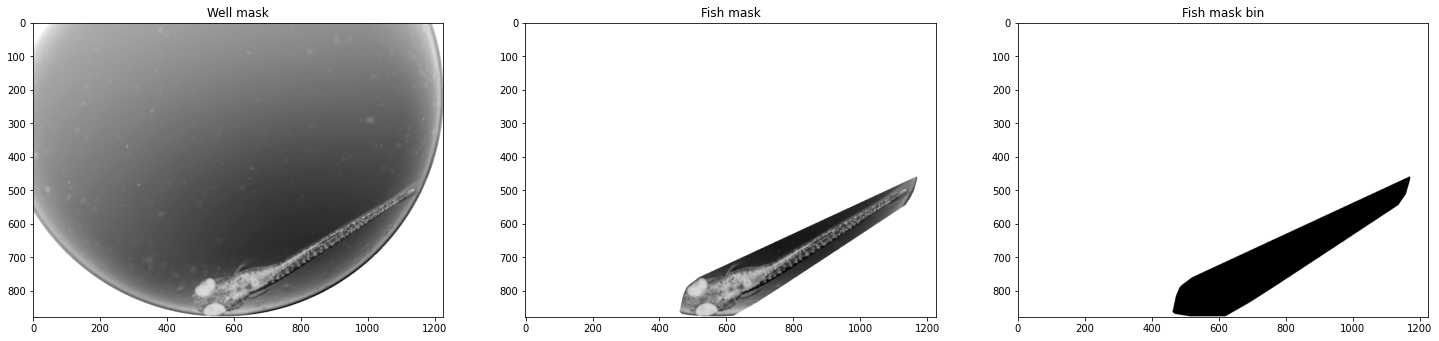

In [14]:
fishy = InputImage("zf6.jpg")
fishy = find_well_props(fishy)

fishy = get_fish_convex_mask(fishy)
fishy = refine_fish_convex_mask(fishy)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 20))
ax[0].imshow(fishy.well_props.mask.cropped_masked, "binary")
ax[0].set_title('Well mask')
ax[1].imshow(fishy.fish_props.mask.masked, "binary")
ax[1].set_title('Fish masked')
ax[2].imshow(fishy.binary, "binary")
ax[2].set_title('Fish mask bin')